In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, integrate
import seaborn as sns
import pickle

In [101]:
curr_dir = !pwd
pfam_version = "31"
domains_th = "10"

hhalign_scores = pd.read_csv(curr_dir[0]+"/pfam-v"+pfam_version+"/domains_hhlign_scores.csv", sep='\t', index_col=0)

#Read the list of domains
with open(curr_dir[0]+"/../../5.domains_stats/pfam-v"+pfam_version+"/filtered"+domains_th+"_list.pik", 'rb') as handle:
    filtered_domains_list = pickle.load(handle)
filtered_domains_list.sort()

with open(curr_dir[0]+"/../../7.InteracDome_targetVariable/domains_ligands_propensity_dict.pik", 'rb') as handle:
    binding_props_dict = pickle.load(handle)
    
domains_prop_intersection = []
for domain in filtered_domains_list:
    if (domain in binding_props_dict.keys()):
        domains_prop_intersection.append(domain)
print "number of domains = "+str(len(domains_prop_intersection))

number of domains = 423


### Remove domains from "no clan" that were accidentally calculated (now it's removed before running hhalign, but keeping this here for pfam-v30)

In [3]:
#Remove domains from "no clan" that were accidentally calculated
clan_path = curr_dir[0]+"/../../2.parse_Pfam/v"+pfam_version+"/"
with open(clan_path+"domain_to_clan_dict.pik", 'rb') as handle:
    domain_to_clan_dict = pickle.load(handle)
with open(clan_path+"clan_to_domains_dict.pik", 'rb') as handle:
    clan_to_domains_dict = pickle.load(handle)

In [4]:
drop_idx = []
for index, row in hhalign_scores.iterrows():
    clan1 = domain_to_clan_dict[row["sim_dom1"]]
    clan2 = domain_to_clan_dict[row["sim_dom2"]]
    if (clan1 == "No_clan" and clan2 == "No_clan"):
        drop_idx.append(index)

In [6]:
hhalign_scores_filtered_no_clan = hhalign_scores.drop(drop_idx)
hhalign_scores_filtered_no_clan = hhalign_scores_filtered_no_clan.reset_index(drop=True)

### Remove domains that aren't a part of our training set (now it's removed before running hhalign, but keeping this here for pfam-v30)

In [103]:
table_idx_for_removal = []
for index, row in hhalign_scores_filtered_no_clan.iterrows():
    domain_name1 = row["sim_dom1"]
    domain_name2 = row["sim_dom2"]
    
    if (domain_name1 not in domains_prop_intersection):
        table_idx_for_removal.append(index)
        continue
    if (domain_name2 not in domains_prop_intersection):
        table_idx_for_removal.append(index)
    
print "total # of removed idx #: "+str(len(table_idx_for_removal))

total # of removed idx #: 698


In [104]:
#Remove from the features table
hhalign_scores_filtered_no_clan = hhalign_scores_filtered_no_clan.drop(table_idx_for_removal)
print "# of pairs after removing domains not in the analysis: "+str(hhalign_scores_filtered_no_clan.shape[0])

# of pairs after removing domains not in the analysis: 1188


### Adding the raw score divided by cols aligned
from the HHsuite userguise: https://github.com/soedinglab/hh-suite/blob/master/hhsuite-userguide.pdf (page 23):

How can I build a phylogenetic tree for HMMs? I would use a similarity measure like
the raw score per alignment length. You might also add the secondary structure score to the
raw score with some weight. Whereas probabilities, E-values, and P-values are useful for deciding
whether a match is a reliable homolog or not, they are not suitable for measuring similarities
because they strongly depend on the length of the alignment

In [105]:
score_alignment_cols_ratio_list1 = []
score_alignment_cols_ratio_list2 = []
for index, row in hhalign_scores_filtered_no_clan.iterrows():
    score_norm = row["score1"]/float(row["aligned_cols1"])
    score_alignment_cols_ratio_list1.append(score_norm)
    score_norm = row["score2"]/float(row["aligned_cols2"])
    score_alignment_cols_ratio_list2.append(score_norm)

hhalign_scores_filtered_no_clan["score_norm1"] = score_alignment_cols_ratio_list1
hhalign_scores_filtered_no_clan["score_norm2"] = score_alignment_cols_ratio_list2

### Check the scores distribution to determine a threshold for similarity

In [106]:
h = np.histogram(hhalign_scores_filtered_no_clan["score_norm1"])

In [107]:
h

(array([652, 229,  91,  63,  78,  32,  24,   9,   7,   3]),
 array([  0.26528302,   1.69575472,   3.12622642,   4.55669811,
          5.98716981,   7.41764151,   8.84811321,  10.27858491,
         11.7090566 ,  13.1395283 ,  14.57      ]))

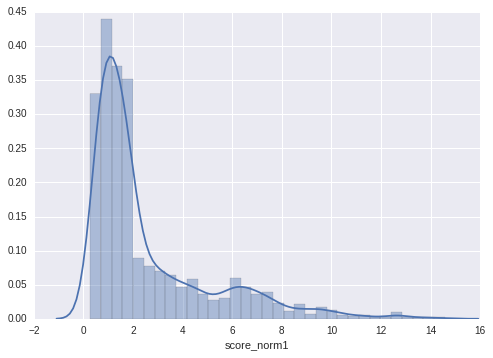

In [109]:
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "distributions")))
sns.distplot(hhalign_scores_filtered_no_clan["score_norm1"]);

This distribution is only of similarity scores within clans, so they are already pretty high and not represnting similarity between two random domains.

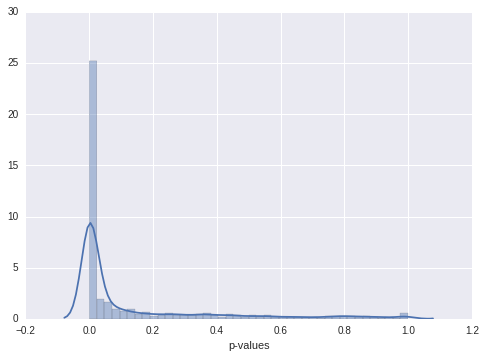

In [12]:
sns.distplot(hhalign_scores_filtered_no_clan["p-values"]);

0.001 p-value is the diffault threshold for Viterbi:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3197634/

In [111]:
#Has both directions with meaningful alignments (pfal <= 0.001, precent identity >= 25)
significantly_pvals = hhalign_scores_filtered_no_clan[hhalign_scores_filtered_no_clan["pval1"] <= 0.001][hhalign_scores_filtered_no_clan["pval2"] <= 0.001]

#According to HHsuite userguide, this is the % of aligned columns that match
significantly_ident_perc = significantly_pvals[significantly_pvals["ident_perc1"] >= 20][significantly_pvals["ident_perc2"] >= 20]

#By HHsuite userguide (page-30): A unit of column score corresponds approximately to 0.6 bits
significantly_score = significantly_ident_perc[significantly_ident_perc["score_norm1"] >= 0.6][significantly_ident_perc["score_norm2"] >= 0.6]

significantly_similar_pairs = significantly_score

In [112]:
significantly_similar_pairs.shape

(360, 15)

In [113]:
#Saving to .csv
significantly_similar_pairs.to_csv("pfam-v"+pfam_version+"/sig_pairs_pvals0.001_ident20_score0.6_2directions.csv", sep='\t')

#### Checking one domain for exmaple

In [116]:
pd.DataFrame.append(significantly_similar_pairs[significantly_similar_pairs["sim_dom1"] == "zf-C2H2"], significantly_similar_pairs[significantly_similar_pairs["sim_dom2"] == "zf-C2H2"])

,index,sim_dom1,sim_dom2,prob1,pval1,score1,aligned_cols1,prob2,pval2,score2,ident_perc2,ident_perc1,aligned_cols2,score_norm1,score_norm2
1764,6845620,zf-C2H2,zf-met,93.45,2.400000e-07,7.99,8,94.71,6.600000e-08,8.63,44,38,9,0.998750,0.958889
1744,6845437,zf-C2H2_4,zf-C2H2,95.49,2.000000e-08,9.45,11,95.00,4.600000e-08,9.03,30,27,10,0.859091,0.903000


### Draft - old condition on raw score
According the HHalign userguide raw score is dependant on length, score should be normalized by number of aligned columns.

HHalign Viterbi score >= 11 like the threshold used in: https://academic.oup.com/nar/article/45/W1/W470/3782606

In [34]:
significantly_similar_pairs = hhalign_scores_filtered_no_clan[hhalign_scores_filtered_no_clan["p-values"] <= 0.001][hhalign_scores_filtered_no_clan["scores"] >= 10]
significantly_similar_pairs.reset_index(inplace=True, drop=True)